# Nistats Tutorial - Single session, single subject fMRI dataset

In this tutorial, we are going to look at the fMRI signal during periods of auditory stimulation versus periods of rest, using General Linear Model (GLM).

Dataset includes 96 scans(repetition time TR=7s), the periods of stimulation and rest lasting 42s each ( that is for 6 scans)

In [1]:
from nistats.datasets import fetch_spm_auditory
import os
import sys
import numpy as np
from nistats.design_matrix import make_first_level_design_matrix, make_second_level_design_matrix
from nistats.design_matrix import check_design_matrix
from nistats.reporting import plot_design_matrix, plot_contrast_matrix
from nistats.first_level_model import FirstLevelModel
%matplotlib inline 

<ipython-input-1-75c4ff42d184>:1: FutureWarning: 

 | Starting with Nilearn 0.7.0, all Nistats functionality has been incorporated into Nilearn's stats & reporting modules.
 | Nistats package will no longer be updated or maintained.

  from nistats.datasets import fetch_spm_auditory
/mnt/tigrlab/projects/ttan/fMRI_tools/.fMRI_env/lib/python3.8/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.datasets.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)
/mnt/tigrlab/projects/ttan/fMRI_tools/.fMRI_env/lib/python3.8/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be

### Load in the functional MRI data

In [2]:
subject_data= fetch_spm_auditory()
subject_data.func

['/home/ttan/nilearn_data/spm_auditory/sub001/fM00223/fM00223_004.img',
 '/home/ttan/nilearn_data/spm_auditory/sub001/fM00223/fM00223_005.img',
 '/home/ttan/nilearn_data/spm_auditory/sub001/fM00223/fM00223_006.img',
 '/home/ttan/nilearn_data/spm_auditory/sub001/fM00223/fM00223_007.img',
 '/home/ttan/nilearn_data/spm_auditory/sub001/fM00223/fM00223_008.img',
 '/home/ttan/nilearn_data/spm_auditory/sub001/fM00223/fM00223_009.img',
 '/home/ttan/nilearn_data/spm_auditory/sub001/fM00223/fM00223_010.img',
 '/home/ttan/nilearn_data/spm_auditory/sub001/fM00223/fM00223_011.img',
 '/home/ttan/nilearn_data/spm_auditory/sub001/fM00223/fM00223_012.img',
 '/home/ttan/nilearn_data/spm_auditory/sub001/fM00223/fM00223_013.img',
 '/home/ttan/nilearn_data/spm_auditory/sub001/fM00223/fM00223_014.img',
 '/home/ttan/nilearn_data/spm_auditory/sub001/fM00223/fM00223_015.img',
 '/home/ttan/nilearn_data/spm_auditory/sub001/fM00223/fM00223_016.img',
 '/home/ttan/nilearn_data/spm_auditory/sub001/fM00223/fM00223_01

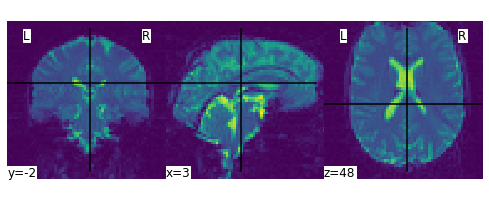

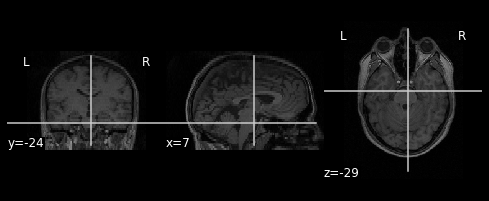

In [3]:
from nilearn.plotting import plot_stat_map, plot_anat, plot_img, show

#plotting the first functional and anatomical data
plot_img(subject_data.func[0])
plot_anat(subject_data.anat)

In [4]:
from nilearn.image import concat_imgs, mean_img

#concat all of the 3D images into a single 4-D nifti file
fmri_img = concat_imgs(subject_data.func)
mean_img = mean_img(fmri_img)

In [5]:
fmri_img.shape

(64, 64, 64, 96)

### Specifying the experimental paradigm

In [6]:
import pandas as pd
#Reading in the event.tsv file
events = pd.read_table(subject_data['events'])
events

,onset,duration,trial_type
0,0.0,42.0,rest
1,42.0,42.0,active
2,84.0,42.0,rest
3,126.0,42.0,active
4,168.0,42.0,rest
5,210.0,42.0,active
6,252.0,42.0,rest
7,294.0,42.0,active
8,336.0,42.0,rest
9,378.0,42.0,active


### Define regressors

In [7]:
n_scans=fmri_img.shape[-1] #total number of scans
t_r=7
frame_times = np.arange(n_scans) * t_r  #The timing of acquisition of the scans in seconds
drift_model = 'polynomial' #Specifies the desired drift model to account for temporal drift patterns
drift_order = 5 #The order numbers of polynomial model
hrf_model = 'spm'  #Specifies the hemodynamic response function from spm
noise_model = 'ar1' #The temporal variance model.

### Create the design matrix

In [8]:
from nistats.design_matrix import make_first_level_design_matrix, make_second_level_design_matrix

design_matrix = make_first_level_design_matrix(frame_times,events,
                                               drift_model=drift_model,
                                               drift_order=drift_order,
                                               hrf_model=hrf_model)
design_matrix

,active,rest,drift_1,drift_2,drift_3,drift_4,drift_5,constant
0,0.000000,0.000000,-0.500000,0.164912,-0.048432,0.013401,-0.003566,1.0
7,0.000000,0.817784,-0.489474,0.154497,-0.042314,0.010580,-0.002440,1.0
14,0.000000,1.129175,-0.478947,0.144303,-0.036522,0.008028,-0.001481,1.0
21,0.000000,1.022902,-0.468421,0.134331,-0.031048,0.005734,-0.000676,1.0
28,0.000000,1.000997,-0.457895,0.124580,-0.025886,0.003683,-0.000011,1.0
...,...,...,...,...,...,...,...,...
637,0.809178,0.190822,0.457895,0.124580,0.025886,0.003683,0.000011,1.0
644,1.129985,-0.129985,0.468421,0.134331,0.031048,0.005734,0.000676,1.0
651,1.023342,-0.023342,0.478947,0.144303,0.036522,0.008028,0.001481,1.0
658,1.001027,-0.001027,0.489474,0.154497,0.042314,0.010580,0.002440,1.0


### Visualize the design matrix

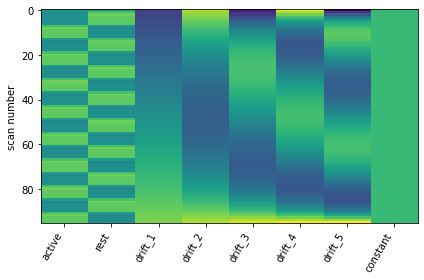

In [9]:
from nistats.reporting import plot_design_matrix
plot_design_matrix(design_matrix)
import matplotlib.pyplot as plt
#plt.show()

Text(0.5, 1.0, 'Expected Auditory Response')

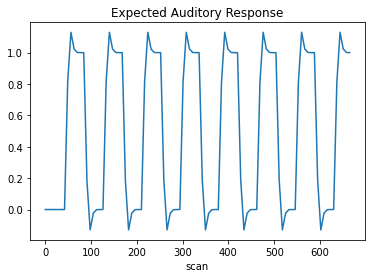

In [15]:
plt.plot(design_matrix['active'])
plt.xlabel('scan')
plt.title('Expected Auditory Response')
#plt.show()

### Performing the GLM analysis on the fMRI data

In [16]:
#Define the GLM parameters for fitting
fmri_glm = FirstLevelModel(t_r=7,
                           noise_model=noise_model,
                           hrf_model=hrf_model,
                           drift_order=drift_order,
                           drift_model=drift_model,
                           standardize=False)

#Fitting the GLM on the fMRI data
fmri_glm = fmri_glm.fit(fmri_img,design_matrices=design_matrix)

In [17]:
fmri_glm

FirstLevelModel(drift_model='polynomial', drift_order=5, fir_delays=[0],
                high_pass=0.01, hrf_model='spm', mask_img=None,
                memory=Memory(location=None), memory_level=1, min_onset=-24,
                minimize_memory=True, n_jobs=1, noise_model='ar1',
                signal_scaling=True, slice_time_ref=0.0, smoothing_fwhm=None,
                standardize=False, subject_label=None, t_r=7,
                target_affine=None, target_shape=None, verbose=0)

### Detecting voxels with significants effects

In [18]:
#Generate canonical contrasts to detect voxels with significant effects
contrast_matrix = np.eye(design_matrix.shape[1])
basic_contrasts = dict([(column, contrast_matrix[i])
                         for i, column in enumerate(design_matrix.columns)])

In [19]:
#Compare to active versus rest condition
active_minus_rest = basic_contrasts['active'] - basic_contrasts['rest']
active_minus_rest

array([ 1., -1.,  0.,  0.,  0.,  0.,  0.,  0.])

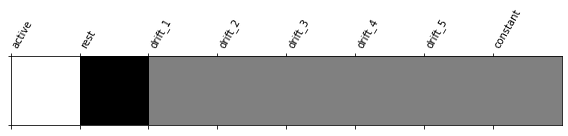

In [20]:
from nistats.reporting import plot_contrast_matrix
plot_contrast_matrix(active_minus_rest, design_matrix=design_matrix)

In [21]:
#Form a t-statistic on the contrast
t_map = fmri_glm.compute_contrast(active_minus_rest,
                                         stat_type='t',
                                         output_type='stat')

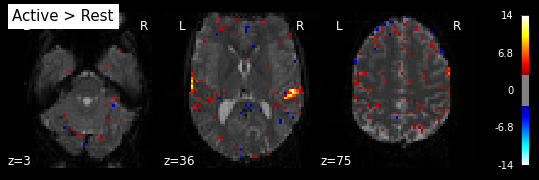

In [22]:
#Plotting the t-statistic map 
plot_stat_map(t_map, bg_img=mean_img, threshold=3.0,
              display_mode='z', cut_coords=3, black_bg=True,
              title='Active > Rest')
plt.show()

In [31]:
from nistats.reporting import make_glm_report

make_glm_report(fmri_glm,
                         basic_contrasts['active_minus_rest'],
                         bg_img=mean_img,
                        )